 # Phase 2: Holding period test

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import matplotlib.pyplot as plt
from matplotlib import style
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from datetime import datetime, timedelta
from dateutil import relativedelta
import calendar
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_data(formation_date, data_universe, equity_data, bond_data, fama_data, TMT):
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = 12)
    
    bond_data_ = bond_data[(bond_data.DATE >= form_date) & (bond_data.DATE <= limitf_date) & (bond_data.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM'])['company_symbol'].unique())
    
    #equity
    avg_date =  form_date - relativedelta.relativedelta(months = 12)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data[(equity_data.date > avg_date) & (equity_data.date <= form_date)]
    equity_data_ = equity_data_.drop_duplicates()
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count == 12].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    del equity_data_
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    bond_data__ = bond_data__[bond_data__.RATING_CAT.isin(universe)]
    del bond_data_
    #fama
    fama_data['dateem'] = pd.to_datetime(pd.PeriodIndex(fama_data.dateff, freq='M').strftime('%Y-%m-%d'), format = '%Y-%m-%d') 
        
    bond_data___ = pd.merge(bond_data__, fama_data[['dateem', 'rf']], how='left', left_on = ['DATE'], right_on=['dateem'])
    bond_data___.YIELD = bond_data___.YIELD.str.replace('%', '').astype('float').divide(100.0)
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    
    equity_data___ = pd.merge(equity_data__, fama_data[['dateff', 'rf']], how='left', left_on = ['date'], right_on=['dateff'])

    return(equity_data___, bond_data___)

In [4]:
def avg_rolling_test(formation_date, data_universe, avg_range, test_period, TMT = 1):

    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = test_period)
    
    bond_data_ = bond_data_raw[(bond_data_raw.DATE >= form_date) & (bond_data_raw.DATE <= limitf_date) & (bond_data_raw.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 24)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data_raw[(equity_data_raw.date > avg_date) & (equity_data_raw.date <= limitf_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
        equity_data_ = equity_data_[equity_data_.RETX != 'B']
    except:
        print('There is no C or B')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    diff_month = (limitf_date.month - avg_date.month) + (limitf_date.year - avg_date.year)*12
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count >= diff_month].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    equity_port = equity_data__.groupby(['date']).agg({'RETX': 'mean'})
    equity_port['bdate'] = pd.to_datetime([datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in equity_port.index])
    
    equity_port['rm_{0}'.format(avg_range[0])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[0])
    equity_port['rm_{0}'.format(avg_range[1])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[1])
    equity_port['rm_{0}'.format(avg_range[2])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[2])
    
    equity_port = equity_port.dropna()
    
    bond_data___ = bond_data__.dropna(subset=['RET_EOM'])
    
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    bond_port = bond_data___.groupby(['DATE']).agg({'RET_EOM': 'mean'})
    
    equity_test = equity_port[['rm_{0}'.format(avg_range[0]), 'rm_{0}'.format(avg_range[1]), 'rm_{0}'.format(avg_range[2])]]
    equity_test.index = equity_port.bdate
    equity_test = equity_test[equity_test.index >= form_date]
    bond_test = bond_port
    
    data_test = equity_test.merge(bond_test, left_index=True, right_index=True)
    data_test['Ret_lag1'] = data_test['RET_EOM'].shift(1)
    data_test['Ret_lag2'] = data_test['RET_EOM'].shift(2)
    data_test['Ret_lag3'] = data_test['RET_EOM'].shift(3)
    data_test['Ret_lag4'] = data_test['RET_EOM'].shift(4)
    data_test['Ret_lag5'] = data_test['RET_EOM'].shift(5)
    data_test['Ret_lag6'] = data_test['RET_EOM'].shift(6)
    data_test['Ret_lag7'] = data_test['RET_EOM'].shift(7)
    data_test['Ret_lag8'] = data_test['RET_EOM'].shift(8)
    data_test['Ret_lag9'] = data_test['RET_EOM'].shift(9)
    data_test['Ret_lag10'] = data_test['RET_EOM'].shift(10)
    data_test['Ret_lag11'] = data_test['RET_EOM'].shift(11)
    data_test['Ret_lag12'] = data_test['RET_EOM'].shift(12)
    corr_test = data_test
    corr_test = corr_test.dropna()
    
    corr_result = corr_test.corr().iloc[3:16,0:3]
    corr_index = corr_result.index.values
    corr_index[0] = 'Ret_lag0'
    corr_result.index = corr_index
    corr_result.columns = ['Rolling_{0}'.format(avg_range[0]), 'Rolling_{0}'.format(avg_range[1]), 'Rolling_{0}'.format(avg_range[2])]
    
    result_ggc = pd.DataFrame(columns = ['Rolling_{0}'.format(avg_range[0]), 'Rolling_{0}'.format(avg_range[1]), 'Rolling_{0}'.format(avg_range[2])],
                              index = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8',
                                       'Lag9', 'Lag10', 'Lag11', 'Lag12'])
    
    ggc3_test = grangercausalitytests(data_test[['rm_{0}'.format(avg_range[0]), 'RET_EOM']], maxlag = 12, verbose=False)
    ggc3_list = []
    for i in range(1, 13):
        ggc3_list.append([i, ggc3_test[i][0]['params_ftest'][1]])
    
    result_ggc['Rolling_{0}'.format(avg_range[0])] = [i[1] for i in ggc3_list]
    
    ggc6_test = grangercausalitytests(data_test[['rm_{0}'.format(avg_range[1]), 'RET_EOM']], maxlag = 12, verbose=False)
    ggc6_list = []
    for i in range(1, 13):
        ggc6_list.append([i, ggc6_test[i][0]['params_ftest'][1]])
    
    result_ggc['Rolling_{0}'.format(avg_range[1])] = [i[1] for i in ggc6_list]
    
    ggc12_test = grangercausalitytests(data_test[['rm_{0}'.format(avg_range[2]), 'RET_EOM']], maxlag = 12, verbose=False)
    ggc12_list = []
    for i in range(1, 13):
        ggc12_list.append([i, ggc12_test[i][0]['params_ftest'][1]])
    
    result_ggc['Rolling_{0}'.format(avg_range[2])] = [i[1] for i in ggc12_list]

    return(corr_result, result_ggc)

In [5]:
def avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period=1, TMT = 1):
    
    if data_universe == 'IG':
        universe = ['AAA', 'AA', 'A', 'BBB']
    elif data_universe == 'HY':
        universe = ['BB', 'B', 'CCC', 'CC']
    else:
        universe = [data_universe]
    
    #bond
    form_date = datetime.strptime(formation_date, '%Y-%m-%d')
    bcheck_last_day = calendar.monthrange(form_date.year, form_date.month)
    form_date = datetime(form_date.year, form_date.month, bcheck_last_day[-1])
    limitf_date =  form_date + relativedelta.relativedelta(months = test_period)
    
    bond_data_ = bond_data_raw[(bond_data_raw.DATE >= form_date) & (bond_data_raw.DATE <= limitf_date) & (bond_data_raw.TMT >= TMT)]
    bond_data_ = bond_data_[bond_data_.RATING_CAT.isin(universe)]
    
    bond_data_ = bond_data_.reset_index()
    bond_data_['form_date'] = form_date
    bond_data_['month'] = (bond_data_.DATE.dt.year - bond_data_.form_date.dt.year)*12 + (bond_data_.DATE.dt.month - bond_data_.form_date.dt.month)
    bcom_list = np.sort(bond_data_[bond_data_['month'] == 1].dropna(subset=['RET_EOM'])['company_symbol'].unique())
    
    #equity  
    avg_date =  form_date - relativedelta.relativedelta(months = 24)
    echeck_last_day = calendar.monthrange(avg_date.year, avg_date.month)
    avg_date = datetime(avg_date.year, avg_date.month, echeck_last_day[-1])
    
    equity_data_ = equity_data_raw[(equity_data_raw.date > avg_date) & (equity_data_raw.date <= limitf_date)]
    equity_data_ = equity_data_.drop_duplicates()
    try:
        equity_data_ = equity_data_[equity_data_.RETX != 'C']
        equity_data_ = equity_data_[equity_data_.RETX != 'B']
    except:
        print('There is no C or B')
    equity_data_.RETX = equity_data_.RETX.astype('float64')
    equity_data_.RET = equity_data_.RET.astype('float64')
    
    equity_data_['month_count'] = equity_data_.date.dt.month
    equity_sum_month = equity_data_.groupby('TICKER').agg({'month_count':'count'})
    
    diff_month = (limitf_date.month - avg_date.month) + (limitf_date.year - avg_date.year)*12
    
    equity_data_ = equity_data_[equity_data_.TICKER.isin(equity_sum_month[equity_sum_month.month_count >= diff_month].index.values)]
       
    equity_data__ = equity_data_[equity_data_.TICKER.isin(bcom_list)]
    ecom_list = np.sort(equity_data__.TICKER.unique())
    
    bond_data__ = bond_data_[bond_data_.company_symbol.isin(ecom_list)]
    
    equity_port = equity_data__.groupby(['date']).agg({'RETX': 'mean'})
    equity_port['bdate'] = pd.to_datetime([datetime(i.year, i.month, calendar.monthrange(i.year, i.month)[-1]) for i in equity_port.index])
    
    equity_port['rm_{0}'.format(avg_range[0])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[0])
    equity_port['rm_{0}'.format(avg_range[1])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[1])
    equity_port['rm_{0}'.format(avg_range[2])] = pd.rolling_mean(equity_port['RETX'], window = avg_range[2])
    
    equity_port = equity_port.dropna()
    
    bond_data___ = bond_data__.dropna(subset=['RET_EOM'])
    
    bond_data___.RET_EOM = bond_data___.RET_EOM.str.replace('%', '').astype('float').divide(100.0)
    bond_port = bond_data___.groupby(['DATE']).agg({'RET_EOM': 'mean'})
    
    equity_test = equity_port[['rm_{0}'.format(avg_range[0]), 'rm_{0}'.format(avg_range[1]), 'rm_{0}'.format(avg_range[2])]]
    equity_test.index = equity_port.bdate
    equity_test = equity_test[equity_test.index >= form_date]
    bond_test = bond_port
    
    data_test = equity_test.merge(bond_test, left_index=True, right_index=True)
    data_test['Ret_lag1'] = data_test['RET_EOM'].shift(1)
    data_test['Ret_lag2'] = data_test['RET_EOM'].shift(2)
    data_test['Ret_lag3'] = data_test['RET_EOM'].shift(3)
    data_test['Ret_lag4'] = data_test['RET_EOM'].shift(4)
    data_test['Ret_lag5'] = data_test['RET_EOM'].shift(5)
    data_test['Ret_lag6'] = data_test['RET_EOM'].shift(6)
    data_test['Ret_lag7'] = data_test['RET_EOM'].shift(7)
    data_test['Ret_lag8'] = data_test['RET_EOM'].shift(8)
    data_test['Ret_lag9'] = data_test['RET_EOM'].shift(9)
    data_test['Ret_lag10'] = data_test['RET_EOM'].shift(10)
    data_test['Ret_lag11'] = data_test['RET_EOM'].shift(11)
    data_test['Ret_lag12'] = data_test['RET_EOM'].shift(12)
    
    data_test_ = data_test.dropna()

    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.preprocessing import StandardScaler
    import xgboost as xgb
    from xgboost import XGBRegressor
    
    scaler = StandardScaler()
    df_ml_test = pd.DataFrame(columns=['Lag1', 'Lag2', 'Lag3', 'Lag4'])
    X = data_test_.iloc[:,4:8].values 
    
    model_name = ['LinearRegression()', 'Ridge(alpha=1.0)', 
             'RandomForestRegressor(max_depth=1000, random_state=0, n_estimators=100)', 
             'ExtraTreesRegressor(max_depth=1000, random_state=0,n_estimators=100)',
             'XGBRegressor(max_depth=1000, random_state=0, n_estimators=100)']
        
    
    for i in range(0, 3):
        y = data_test_.iloc[:, i].values
        
        df_lm_temp = pd.DataFrame(columns=['Lag1', 'Lag2', 'Lag3', 'Lag4'], index=range(0, 5))
        index_name = ['LinearRegression_{0}'.format(avg_range[i]), 'RidgeRegression_{0}'.format(avg_range[i]),
                      'RandomForest_{0}'.format(avg_range[i]), 'ExtraTrees_{0}'.format(avg_range[i]), 
                      'XGBoost_{0}'.format(avg_range[i])]
        
        for j in range(0, 5):
            model = model_name[j]
            rfe = RFE(eval(model), holding_period)
            rfe = rfe.fit(scaler.fit_transform(X), y)
            df_lm_temp.iloc[j, :] = rfe.ranking_
            
        df_lm_temp.index = index_name
        df_ml_test = df_ml_test.append(df_lm_temp)
    
    return(df_ml_test)

# Backtesting

In [6]:
bond_data_raw = pd.read_csv('bond_data.txt', sep='\t')
bond_data_raw.DATE = pd.to_datetime(bond_data_raw.DATE, format = '%d%b%Y')

equity_data_raw = pd.read_csv('equity_data.txt', sep='\t')
equity_data_raw.date = pd.to_datetime(equity_data_raw.date, format = '%Y%m%d')

fama_data_raw = pd.read_csv('fama_data.txt', sep='\t')
fama_data_raw.dateff = pd.to_datetime(fama_data_raw.dateff, format = '%Y%m%d')

In [7]:
formation_date = '2003-12-31' #first formation date
strat_type = 0 #total momentum strategy
holding_range = (0, 1) #Hold bonds at the first month after the formation date
TMT = 1 #Include time-to-maturity over 1 year
avg_range = (3, 6, 12) #Average equity ranges of testing
test_period = 12*10 #Test 10 years back

## IG universe

In [8]:
data_universe = 'IG'

In [9]:
corr_test_IG, ggc_test_IG = avg_rolling_test(formation_date, data_universe, avg_range, test_period)

Correlation and Granger Causality test between rolling mean time series of equity returns and lagged bond returns

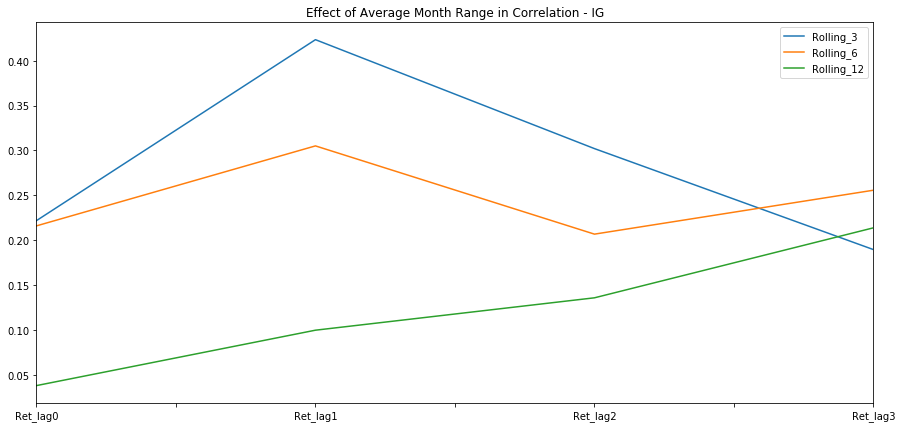

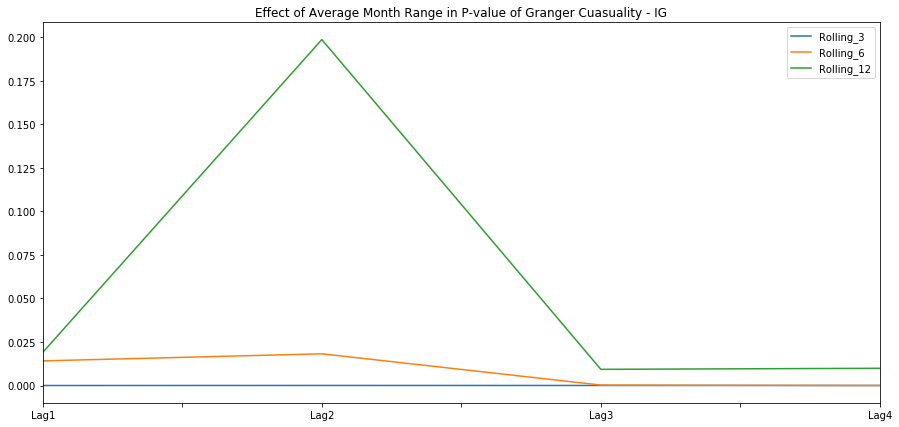

In [10]:
corr_test_IG.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in Correlation - {0}'.format(data_universe))
ggc_test_IG.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in P-value of Granger Cuasuality - {0}'.format(data_universe))

P-values from Ganger Causality test

In [11]:
ggc_test_IG

,Rolling_3,Rolling_6,Rolling_12
Lag1,0.000004,0.014129,0.019052
Lag2,0.000034,0.018196,0.198543
Lag3,0.000022,0.000256,0.009284
Lag4,0.000007,0.000002,0.009889
Lag5,0.000064,0.000109,0.021701
Lag6,0.000066,0.000155,0.073048
Lag7,0.001588,0.001492,0.128064
Lag8,0.006709,0.002990,0.103866
Lag9,0.017315,0.007856,0.167535
Lag10,0.039030,0.015101,0.114596


Machine learning ranks the most important lag.

In [12]:
ml_test_IG = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period=1)
ml_test_IG

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,3.0,4.0,2.0
RidgeRegression_3,1.0,3.0,4.0,2.0
RandomForest_3,1.0,2.0,4.0,3.0
ExtraTrees_3,1.0,3.0,2.0,4.0
XGBoost_3,1.0,2.0,3.0,4.0
LinearRegression_6,2.0,4.0,3.0,1.0
RidgeRegression_6,2.0,4.0,3.0,1.0
RandomForest_6,1.0,3.0,4.0,2.0
ExtraTrees_6,1.0,2.0,4.0,3.0
XGBoost_6,1.0,2.0,4.0,3.0


Machine learning ranks top 3 lags.

In [13]:
ml_test_IG = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period=3)
ml_test_IG

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,1.0,2.0,1.0
RidgeRegression_3,1.0,1.0,2.0,1.0
RandomForest_3,1.0,1.0,2.0,1.0
ExtraTrees_3,1.0,1.0,1.0,2.0
XGBoost_3,1.0,1.0,1.0,2.0
LinearRegression_6,1.0,2.0,1.0,1.0
RidgeRegression_6,1.0,2.0,1.0,1.0
RandomForest_6,1.0,1.0,2.0,1.0
ExtraTrees_6,1.0,1.0,2.0,1.0
XGBoost_6,1.0,1.0,2.0,1.0


## BBB universe

In [16]:
data_universe = 'BBB'

In [17]:
corr_test_BBB, ggc_test_BBB = avg_rolling_test(formation_date, data_universe, avg_range, test_period)

Correlation and Granger Causality test between rolling mean time series of equity returns and lagged bond returns

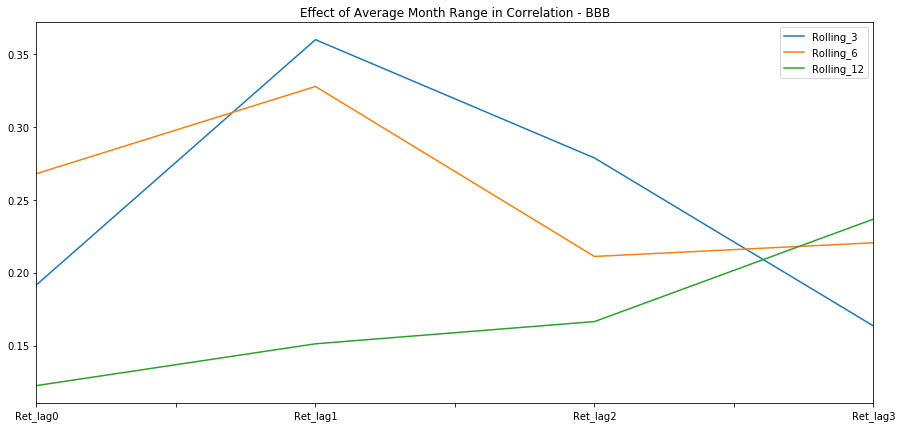

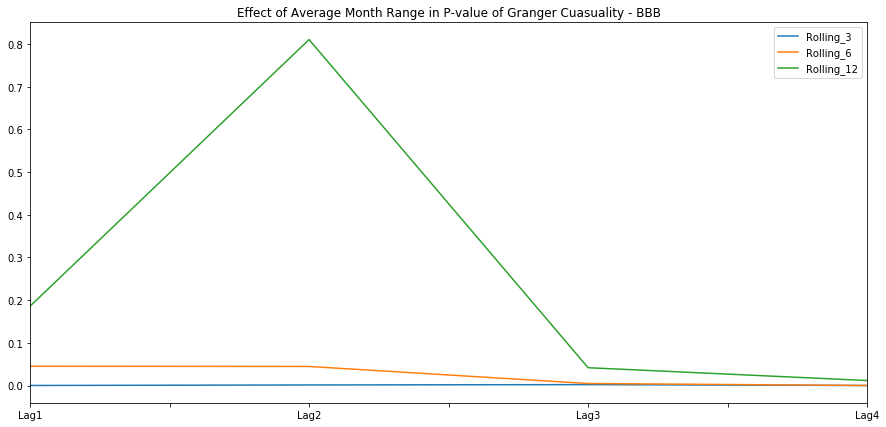

In [18]:
corr_test_BBB.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in Correlation - {0}'.format(data_universe))
ggc_test_BBB.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in P-value of Granger Cuasuality - {0}'.format(data_universe))

P-values from Ganger Causality test

In [19]:
ggc_test_BBB

,Rolling_3,Rolling_6,Rolling_12
Lag1,0.000102,0.045070,0.185836
Lag2,0.001297,0.044632,0.810307
Lag3,0.002096,0.004710,0.041706
Lag4,0.000038,0.000026,0.011702
Lag5,0.000328,0.000905,0.047294
Lag6,0.000421,0.001869,0.077750
Lag7,0.002687,0.006195,0.090045
Lag8,0.012572,0.022112,0.083177
Lag9,0.020545,0.035837,0.127797
Lag10,0.025195,0.034407,0.168630


Machine learning ranks the most important lag.

In [20]:
ml_test_BBB = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 1)
ml_test_BBB

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,3.0,4.0,2.0
RidgeRegression_3,1.0,3.0,4.0,2.0
RandomForest_3,1.0,2.0,4.0,3.0
ExtraTrees_3,1.0,2.0,3.0,4.0
XGBoost_3,1.0,2.0,3.0,4.0
LinearRegression_6,2.0,3.0,4.0,1.0
RidgeRegression_6,2.0,3.0,4.0,1.0
RandomForest_6,1.0,3.0,4.0,2.0
ExtraTrees_6,1.0,2.0,4.0,3.0
XGBoost_6,1.0,2.0,4.0,3.0


Machine learning ranks top 3 lags.

In [21]:
ml_test_BBB = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 3)
ml_test_BBB

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,1.0,2.0,1.0
RidgeRegression_3,1.0,1.0,2.0,1.0
RandomForest_3,1.0,1.0,2.0,1.0
ExtraTrees_3,1.0,1.0,1.0,2.0
XGBoost_3,1.0,1.0,1.0,2.0
LinearRegression_6,1.0,1.0,2.0,1.0
RidgeRegression_6,1.0,1.0,2.0,1.0
RandomForest_6,1.0,1.0,2.0,1.0
ExtraTrees_6,1.0,1.0,2.0,1.0
XGBoost_6,1.0,1.0,2.0,1.0


# HY universe

In [22]:
data_universe = 'HY'

In [23]:
corr_test_HY, ggc_test_HY = avg_rolling_test(formation_date, data_universe, avg_range, test_period)

Correlation and Granger Causality test between rolling mean time series of equity returns and lagged bond returns

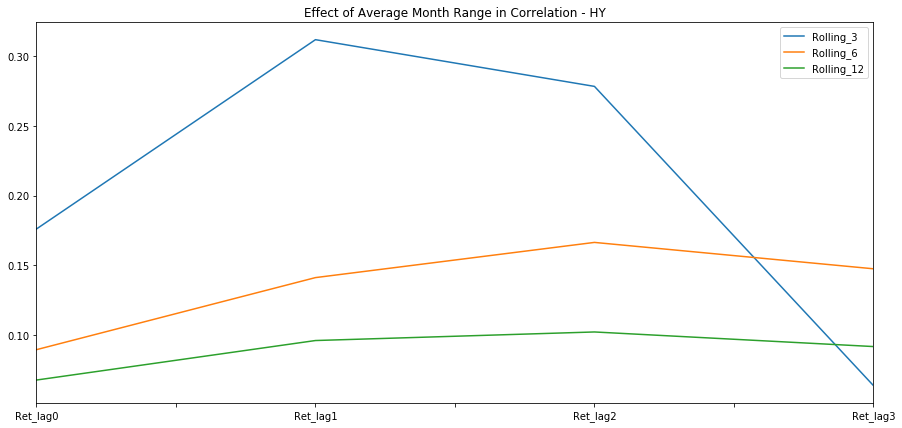

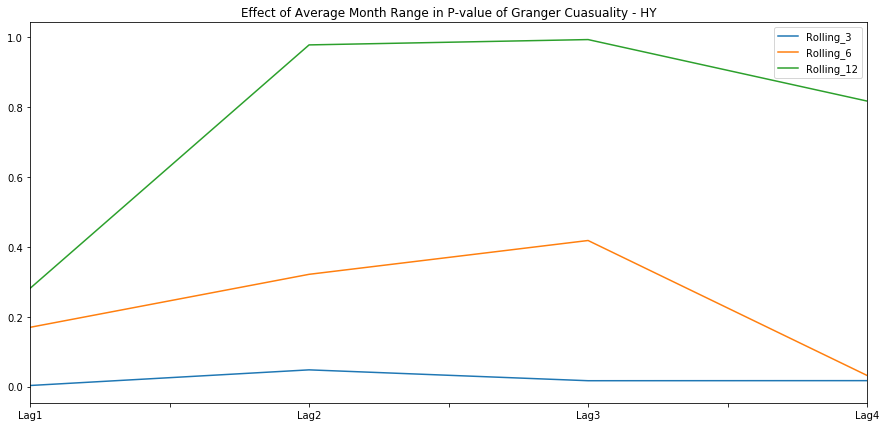

In [24]:
corr_test_HY.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in Correlation - {0}'.format(data_universe))
ggc_test_HY.iloc[0:4,:].plot(figsize=(15, 7), title ='Effect of Average Month Range in P-value of Granger Cuasuality - {0}'.format(data_universe))

P-values from Ganger Causality test

In [25]:
ggc_test_HY

,Rolling_3,Rolling_6,Rolling_12
Lag1,0.002910,0.169517,0.281141
Lag2,0.047721,0.321288,0.978243
Lag3,0.016615,0.418116,0.993493
Lag4,0.016849,0.031681,0.817413
Lag5,0.041385,0.101983,0.902261
Lag6,0.027881,0.001756,0.778113
Lag7,0.046892,0.039210,0.478639
Lag8,0.101316,0.100919,0.455391
Lag9,0.095591,0.085485,0.414351
Lag10,0.150434,0.108801,0.517881


Machine learning ranks the most important lag.

In [26]:
ml_test_HY = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 1)
ml_test_HY

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,2.0,4.0,3.0
RidgeRegression_3,1.0,2.0,4.0,3.0
RandomForest_3,2.0,1.0,3.0,4.0
ExtraTrees_3,1.0,2.0,3.0,4.0
XGBoost_3,1.0,2.0,3.0,4.0
LinearRegression_6,3.0,2.0,4.0,1.0
RidgeRegression_6,3.0,2.0,4.0,1.0
RandomForest_6,1.0,2.0,3.0,4.0
ExtraTrees_6,1.0,2.0,3.0,4.0
XGBoost_6,1.0,2.0,3.0,4.0


Machine learning ranks top 3 lags.

In [27]:
ml_test_HY = avg_rolling_ml_test(formation_date, data_universe, avg_range, test_period, holding_period = 3)
ml_test_HY

,Lag1,Lag2,Lag3,Lag4
LinearRegression_3,1.0,1.0,2.0,1.0
RidgeRegression_3,1.0,1.0,2.0,1.0
RandomForest_3,1.0,1.0,1.0,2.0
ExtraTrees_3,1.0,1.0,1.0,2.0
XGBoost_3,1.0,1.0,1.0,2.0
LinearRegression_6,1.0,1.0,2.0,1.0
RidgeRegression_6,1.0,1.0,2.0,1.0
RandomForest_6,1.0,1.0,1.0,2.0
ExtraTrees_6,1.0,1.0,1.0,2.0
XGBoost_6,1.0,1.0,1.0,2.0


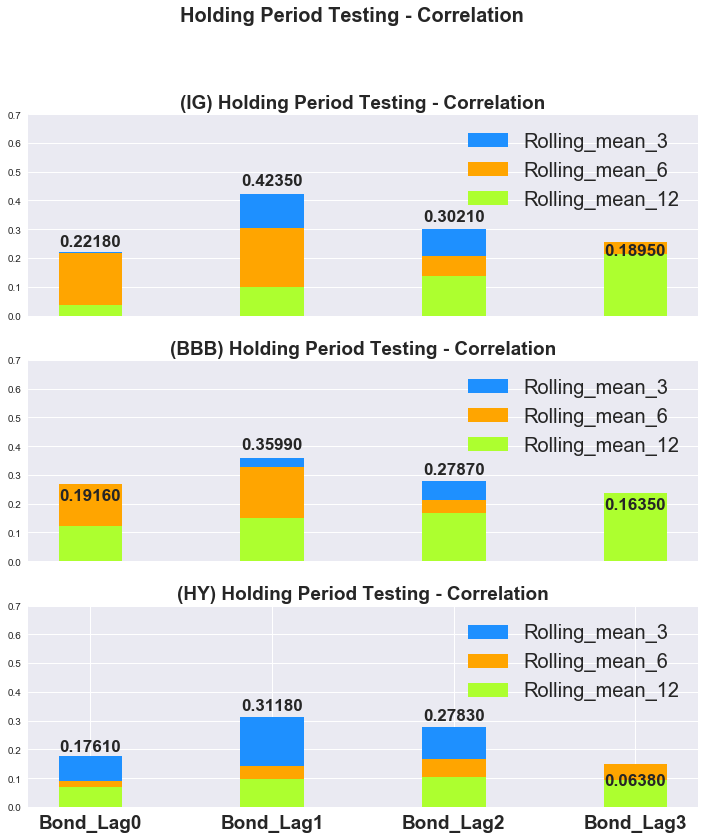

In [28]:
from matplotlib import style
style.use('seaborn')

fig = plt.figure(figsize=(12, 15))
fig.suptitle('Holding Period Testing - Correlation', fontsize=20, fontweight='bold')

ax1 = plt.subplot2grid((40, 15), (0, 0), rowspan=10, colspan=15)

index = np.arange(4)
bar_width = 0.35
opacity = 0.6

rect11 = ax1.bar(index, corr_test_IG.iloc[0:4, 0].round(4).values, bar_width, color='dodgerblue', label="Rolling_mean_3")
for rect in rect11:
    height1 = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, 1.05*height1,
                "{0:0.5f}".format(height1),
               ha='center', va='bottom', fontsize=17, weight='bold')

rect21 = ax1.bar(index, corr_test_IG.iloc[0:4, 1].round(4).values, bar_width, color='orange', label="Rolling_mean_6")
#for rect in rect21:
#    height1 = rect.get_height()
#    ax1.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
    
rect31 = ax1.bar(index, corr_test_IG.iloc[0:4, 2].round(4).values, bar_width, color='greenyellow', label="Rolling_mean_12")
#for rect in rect31:
#    height1 = rect.get_height()
#    ax1.text(rect.get_x() + rect.get_width()/2, 0.90*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
ax1.set_xticks(index)
ax1.set_xticklabels(('Bond_Lag0', 'Bond_Lag1', 'Bond_Lag2', 'Bond_Lag3'), fontsize=19, weight='bold')
ax1.xaxis.set_visible(False)
ax1.set_ylim([0, 0.7])
ax1.set_title('(IG) Holding Period Testing - Correlation', fontsize=19, weight='bold')
ax1.legend(fontsize=20)


##################################################################################################################   

ax2 = plt.subplot2grid((40, 15), (12, 0), rowspan=10, colspan=15)

index = np.arange(4)
bar_width = 0.35
opacity = 0.6

rect12 = ax2.bar(index, corr_test_BBB.iloc[0:4, 0].round(4).values, bar_width, color='dodgerblue', label="Rolling_mean_3")
for rect in rect12:
    height1 = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, 1.05*height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=17, weight='bold')

rect22 = ax2.bar(index, corr_test_BBB.iloc[0:4, 1].round(4).values, bar_width, color='orange', label="Rolling_mean_6")
#for rect in rect22:
#    height1 = rect.get_height()
#    ax2.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
    
rect32 = ax2.bar(index, corr_test_BBB.iloc[0:4, 2].round(4).values, bar_width, color='greenyellow', label="Rolling_mean_12")
#for rect in rect22:
#    height1 = rect.get_height()
#    ax2.text(rect.get_x() + rect.get_width()/2, 0.90*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
ax2.set_xticks(index)
ax2.set_xticklabels(('Bond_Lag0', 'Bond_Lag1', 'Bond_Lag2', 'Bond_Lag3'), fontsize=19, weight='bold')
ax2.xaxis.set_visible(False)
ax2.set_ylim([0, 0.7])
ax2.set_title('(BBB) Holding Period Testing - Correlation', fontsize=19, weight='bold')
ax2.legend(fontsize=20)

##################################################################################################################   

ax3 = plt.subplot2grid((40, 15), (24, 0), rowspan=10, colspan=15)

index = np.arange(4)
bar_width = 0.35
opacity = 0.6

rect13 = ax3.bar(index, corr_test_HY.iloc[0:4, 0].round(4).values, bar_width, color='dodgerblue', label="Rolling_mean_3")
for rect in rect13:
    height1 = rect.get_height()
    ax3.text(rect.get_x() + rect.get_width()/2, 1.05*height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=17, weight='bold')

rect23 = ax3.bar(index, corr_test_HY.iloc[0:4, 1].round(4).values, bar_width, color='orange', label="Rolling_mean_6")
#for rect in rect23:
#    height1 = rect.get_height()
#    ax3.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
    
rect33 = ax3.bar(index, corr_test_HY.iloc[0:4, 2].round(4).values, bar_width, color='greenyellow', label="Rolling_mean_12")
#for rect in rect23:
#    height1 = rect.get_height()
#    ax3.text(rect.get_x() + rect.get_width()/2, 0.90*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
ax3.set_xticks(index)
ax3.set_xticklabels(('Bond_Lag0', 'Bond_Lag1', 'Bond_Lag2', 'Bond_Lag3'), fontsize=19, weight='bold')
ax3.set_ylim([0, 0.7])
ax3.set_title('(HY) Holding Period Testing - Correlation', fontsize=19, weight='bold')
ax3.legend(fontsize=20)


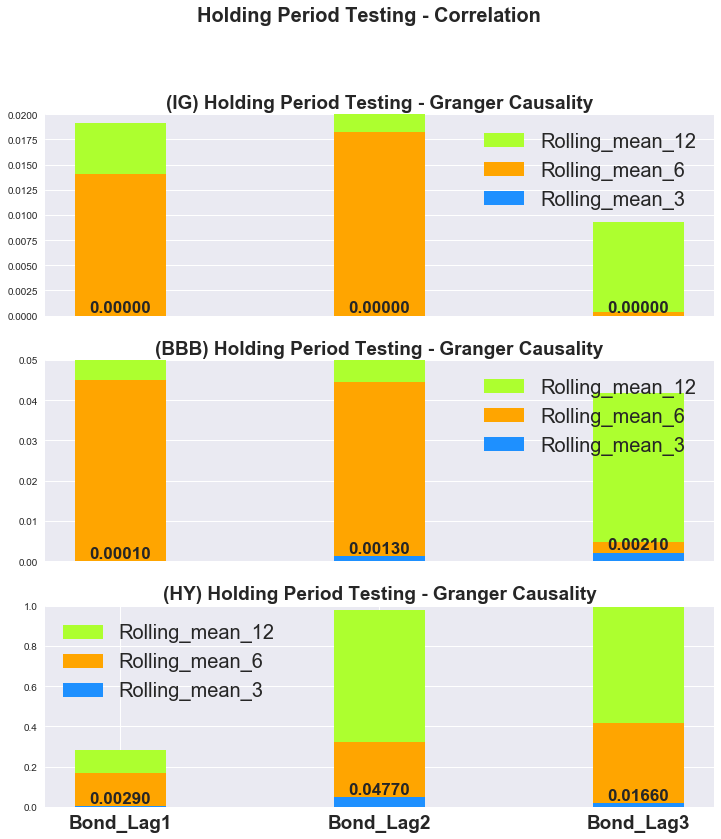

In [29]:
from matplotlib import style
style.use('seaborn')

fig = plt.figure(figsize=(12, 15))
fig.suptitle('Holding Period Testing - Granger Causality', fontsize=20, fontweight='bold')

ax1 = plt.subplot2grid((40, 15), (0, 0), rowspan=10, colspan=15)

index = np.arange(3)
bar_width = 0.35
opacity = 0.6

    
rect31 = ax1.bar(index, ggc_test_IG.iloc[0:3, 2].round(4).values, bar_width, color='greenyellow', label="Rolling_mean_12")
#for rect in rect31:
#    height1 = rect.get_height()
#    ax1.text(rect.get_x() + rect.get_width()/2, 0.90*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')


rect21 = ax1.bar(index, ggc_test_IG.iloc[0:3, 1].round(4).values, bar_width, color='orange', label="Rolling_mean_6")
#for rect in rect21:
#    height1 = rect.get_height()
#    ax1.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')


rect11 = ax1.bar(index, ggc_test_IG.iloc[0:3, 0].round(4).values, bar_width, color='dodgerblue', label="Rolling_mean_3")
for rect in rect11:
    height1 = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, 1.05*height1,
                "{0:0.5f}".format(height1),
               ha='center', va='bottom', fontsize=17, weight='bold')
ax1.set_xticks(index)
ax1.set_xticklabels(('Bond_Lag0', 'Bond_Lag1', 'Bond_Lag2', 'Bond_Lag3'), fontsize=19, weight='bold')
ax1.xaxis.set_visible(False)
ax1.set_ylim([0, 0.02])
ax1.set_title('(IG) Holding Period Testing - Granger Causality', fontsize=19, weight='bold')
ax1.legend(fontsize=20, facecolor="red")

##################################################################################################################   

ax2 = plt.subplot2grid((40, 15), (12, 0), rowspan=10, colspan=15)

index = np.arange(3)
bar_width = 0.35
opacity = 0.6

rect32 = ax2.bar(index, ggc_test_BBB.iloc[0:3, 2].round(4).values, bar_width, color='greenyellow', label="Rolling_mean_12")
#for rect in rect22:
#    height1 = rect.get_height()
#    ax2.text(rect.get_x() + rect.get_width()/2, 0.90*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')

rect22 = ax2.bar(index, ggc_test_BBB.iloc[0:3, 1].round(4).values, bar_width, color='orange', label="Rolling_mean_6")
#for rect in rect22:
#    height1 = rect.get_height()
#    ax2.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')
    

rect12 = ax2.bar(index, ggc_test_BBB.iloc[0:3, 0].round(4).values, bar_width, color='dodgerblue', label="Rolling_mean_3")
for rect in rect12:
    height1 = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, 1.05*height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=17, weight='bold')
ax2.set_xticks(index)
ax2.set_xticklabels(('Bond_Lag0', 'Bond_Lag1', 'Bond_Lag2', 'Bond_Lag3'), fontsize=19, weight='bold')
ax2.xaxis.set_visible(False)
ax2.set_ylim([0, 0.05])
ax2.set_title('(BBB) Holding Period Testing - Granger Causality', fontsize=19, weight='bold')
ax2.legend(fontsize=20)

##################################################################################################################   

ax3 = plt.subplot2grid((40, 15), (24, 0), rowspan=10, colspan=15)

index = np.arange(3)
bar_width = 0.35
opacity = 0.6

    
rect33 = ax3.bar(index, ggc_test_HY.iloc[0:3, 2].round(4).values, bar_width, color='greenyellow', label="Rolling_mean_12")
#for rect in rect23:
#    height1 = rect.get_height()
#    ax3.text(rect.get_x() + rect.get_width()/2, 0.90*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')

rect23 = ax3.bar(index, ggc_test_HY.iloc[0:3, 1].round(4).values, bar_width, color='orange', label="Rolling_mean_6")
#for rect in rect23:
#    height1 = rect.get_height()
#    ax3.text(rect.get_x() + rect.get_width()/2, 0.95*height1,
#                "{0:0.5f}".format(height1),
#                ha='center', va='bottom', fontsize=17, weight='bold')

rect13 = ax3.bar(index, ggc_test_HY.iloc[0:3, 0].round(4).values, bar_width, color='dodgerblue', label="Rolling_mean_3")
for rect in rect13:
    height1 = rect.get_height()
    ax3.text(rect.get_x() + rect.get_width()/2, 1.05*height1,
                "{0:0.5f}".format(height1),
                ha='center', va='bottom', fontsize=17, weight='bold')



ax3.set_xticks(index)
ax3.set_xticklabels(('Bond_Lag1', 'Bond_Lag2', 'Bond_Lag3'), fontsize=19, weight='bold')
ax3.set_ylim([0, 1])
ax3.set_title('(HY) Holding Period Testing - Granger Causality', fontsize=19, weight='bold')
ax3.legend(fontsize=20)